<a href="https://colab.research.google.com/github/btphan95/simple-cnn/blob/master/10_Minutes_to_Building_a_Simple_CNN_Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Building a CNN Image Classifier



The following python code will use the OS library to use Operating System libraries, giving you access to the file system, and the zipfile library allowing you to unzip the data. 

In [1]:
#dataset download
#https://u.pcloud.link/publink/show?code=XZUSYHXZ9jUmDg6oOtJeEQPYP3jVG8HNtwoy

In [16]:
import os
import zipfile

local_zip = 'dataset/Dandelion_grass_dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('dataset/')
zip_ref.close()

In [18]:
local_zip = 'dataset/Dandelion_grass_dataset/train.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('dataset/Dandelion_grass_dataset/')
zip_ref.close()

In [19]:
local_zip = 'dataset/Dandelion_grass_dataset/valid.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('dataset/Dandelion_grass_dataset/')
zip_ref.close()

The contents of the .zip are extracted to the directory `/tmp/train`, which in turn each contain `dandelion` and `grass` subdirectories.

What you'll see later on is that we will use the [ImageGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) class to automatically create our dataset from this train directory, using the subdirectories for classes.

Let's define each of these subdirectories:

In [20]:
# Directory with our training dandelion pictures
train_dandelion_dir = os.path.join('dataset/Dandelion_grass_dataset/train/dandelion')

# Directory with our training grass pictures
train_grass_dir = os.path.join('dataset/Dandelion_grass_dataset/train/grass')

# Directory with our validation dandelion pictures
valid_dandelion_dir = os.path.join('dataset/Dandelion_grass_dataset/valid/dandelion')

# Directory with our validation grass pictures
valid_grass_dir = os.path.join('dataset/Dandelion_grass_dataset/valid/grass')
print("done")

done


Now, let's see what the filenames look like in the `dandelion` and `grass` training directories:

In [21]:
train_dandelion_dir

'dataset/Dandelion_grass_dataset/train/dandelion'

In [22]:
train_dandelion_names = os.listdir(train_dandelion_dir)
print(train_dandelion_names[:10])

train_grass_names = os.listdir(train_grass_dir)
print(train_grass_names[:10])



['00000000.jpg', '00000001.jpg', '00000002.jpg', '00000003.jpg', '00000004.jpg', '00000005.jpg', '00000006.jpg', '00000007.jpg', '00000008.jpg', '00000009.jpg']
['00000000.jpg', '00000001.jpg', '00000002.jpg', '00000003.jpg', '00000004.jpg', '00000005.jpg', '00000006.jpg', '00000007.jpg', '00000008.jpg', '00000009.jpg']


Let's find out the total number of dandelion and grass images in the directories:

In [23]:
print('total training dandelion images:', len(os.listdir(train_dandelion_dir)))
print('total training grass images:', len(os.listdir(train_grass_dir)))


total training dandelion images: 500
total training grass images: 499


Now let's take a look at a few pictures to get a better sense of what they look like. First, configure the matplot parameters:

In [24]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

Now, display a batch of 8 dandelion and 8 grass pictures. You can rerun the cell to see a fresh batch each time:

dataset/Dandelion_grass_dataset/train/dandelion\00000008.jpg
dataset/Dandelion_grass_dataset/train/dandelion\00000009.jpg
dataset/Dandelion_grass_dataset/train/dandelion\00000010.jpg
dataset/Dandelion_grass_dataset/train/dandelion\00000011.jpg
dataset/Dandelion_grass_dataset/train/dandelion\00000012.jpg
dataset/Dandelion_grass_dataset/train/dandelion\00000013.jpg
dataset/Dandelion_grass_dataset/train/dandelion\00000014.jpg
dataset/Dandelion_grass_dataset/train/dandelion\00000015.jpg
dataset/Dandelion_grass_dataset/train/grass\00000008.jpg
dataset/Dandelion_grass_dataset/train/grass\00000009.jpg
dataset/Dandelion_grass_dataset/train/grass\00000010.jpg
dataset/Dandelion_grass_dataset/train/grass\00000011.jpg
dataset/Dandelion_grass_dataset/train/grass\00000012.jpg
dataset/Dandelion_grass_dataset/train/grass\00000013.jpg
dataset/Dandelion_grass_dataset/train/grass\00000014.jpg
dataset/Dandelion_grass_dataset/train/grass\00000015.jpg


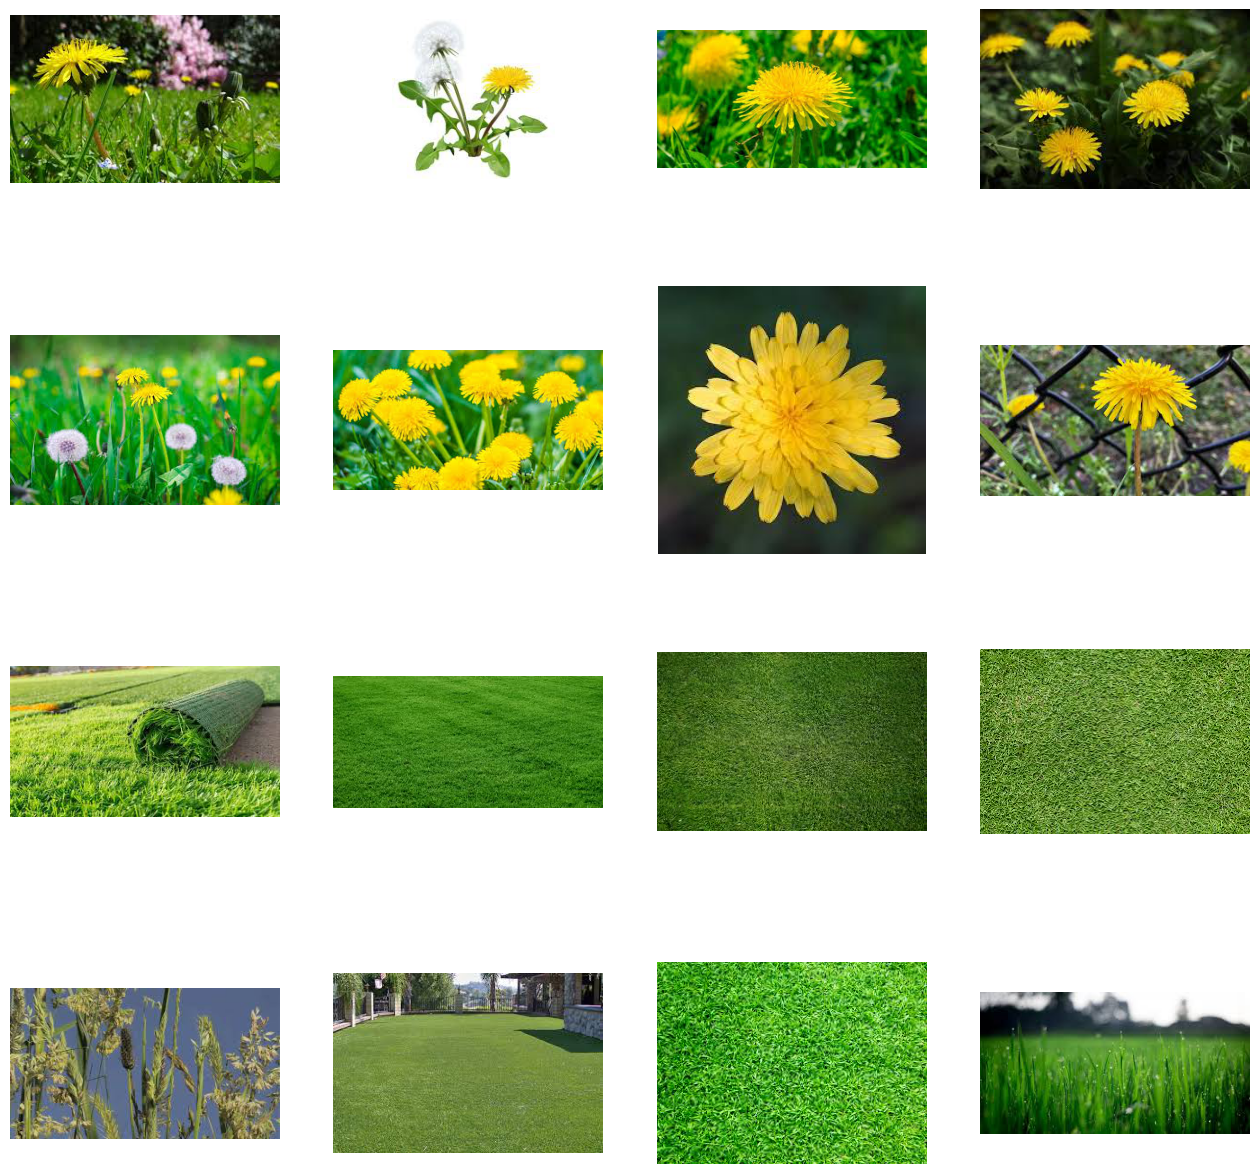

In [26]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_dandelion_pic = [os.path.join(train_dandelion_dir, fname) 
                for fname in train_dandelion_names[pic_index-8:pic_index]]
next_grass_pic = [os.path.join(train_grass_dir, fname) 
                for fname in train_grass_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_dandelion_pic + next_grass_pic):
  print(img_path)
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


In [27]:
import tensorflow as tf
tf.__version__

'2.11.0'

We then add convolutional layers as in the previous example, and flatten the final result to feed into the densely connected layers.

First, let's add convolutional layers, and then flatten the result to feed into dense layers.

Note that because our goal is to perform binary classification, our final layer will be a sigmoid, so that the output of our network will be a single scalar between 0 and 1, encoding the probability that the current image is of class 1 (class 1 being grass and class 0 being dandelion).

In [28]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 200x200 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(200, 200, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('dandelions') and 1 for the other ('grass')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [29]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['accuracy'])

### Data Preprocessing

Now ,let's use `keras.preprocessing.image.ImageDataGenerator` class to create our train and validation dataset and normalize our data. 

It's important to normalize our data because data going into our CNN to improve its overall performance. We will use the `rescale` parameter to scale our image pixel values from [0, 255] to [0,1].

In each generator, we specify the source directory of our images, the classes, the input image size, the batch size (how many images to process at once), and class mode.

In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 120 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        'dataset/Dandelion_grass_dataset/train/',  # This is the source directory for training images
        classes = ['dandelion', 'grass'],
        target_size=(200, 200),  # All images will be resized to 200x200
        batch_size=120,
        # Use binary labels
        class_mode='binary')

# Flow validation images in batches of 19 using valid_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        'dataset/Dandelion_grass_dataset/valid/',  # This is the source directory for training images
        classes = ['dandelion', 'grass'],
        target_size=(200, 200),  # All images will be resized to 200x200
        batch_size=19,
        # Use binary labels
        class_mode='binary')

Found 999 images belonging to 2 classes.
Found 157 images belonging to 2 classes.


### Training
Let's train for 15 epochs -- this may take a few minutes to run.

Note that steps_per_epoch was set along with batch_size in ImageDataGenerator so that steps_per_epoch * batch_size = total # of images. For example, for training, 8 * 120 = 960, just under our total of 999 images.

Notice that as we train, our validation accuracy never exceeds training accuracy, which is a good thing. Our model won't work better on unseen images than seen images.

In [40]:
history = model.fit(
      train_generator,
      steps_per_epoch=8,  
      epochs=15,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8)

Epoch 1/15
8/8 [==============================] - 51s 7s/step - loss: 0.4667 - accuracy: 0.7782 - val_loss: 0.6062 - val_accuracy: 0.6842
Epoch 2/15
8/8 [==============================] - 46s 6s/step - loss: 0.4787 - accuracy: 0.7804 - val_loss: 0.5306 - val_accuracy: 0.7368
Epoch 3/15
8/8 [==============================] - 39s 5s/step - loss: 0.4475 - accuracy: 0.7918 - val_loss: 0.5449 - val_accuracy: 0.7105
Epoch 4/15
8/8 [==============================] - 31s 4s/step - loss: 0.4740 - accuracy: 0.7600 - val_loss: 0.5600 - val_accuracy: 0.7434
Epoch 5/15
8/8 [==============================] - 25s 3s/step - loss: 0.4678 - accuracy: 0.7656 - val_loss: 0.5267 - val_accuracy: 0.7632
Epoch 6/15
8/8 [==============================] - 24s 3s/step - loss: 0.4190 - accuracy: 0.8020 - val_loss: 0.5308 - val_accuracy: 0.7632
Epoch 7/15
8/8 [==============================] - 23s 3s/step - loss: 0.4267 - accuracy: 0.8111 - val_loss: 0.5474 - val_accuracy: 0.7500
Epoch 8/15
8/8 [==================

KeyboardInterrupt: 

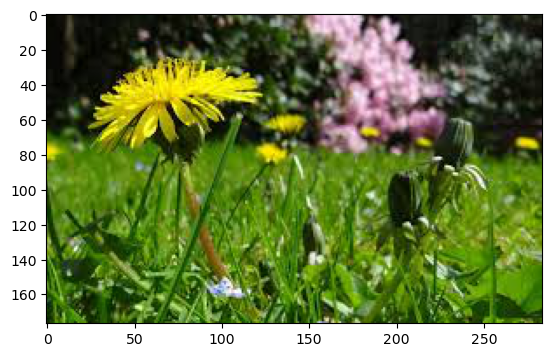

In [38]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow import keras
fpath="dataset/Dandelion_grass_dataset/train/dandelion"
filename="00000008.jpg"
image_file=fpath+"\\"+filename
        
img = image.load_img(image_file)
import matplotlib.pyplot as plt
plt.imshow(img)


In [39]:
img = image.load_img(image_file, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=10)
print(classes)
if classes[0]<0.5:
    print(filename + " is a dandelion")
else:
    print(filename + " is a grass")

1/1 [==============================] - 0s 265ms/step
[[3.7830134e-22]]
00000008.jpg is a dandelion


In [ ]:
#Graphing our training and validation
acc = history.history['accuracy']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.show()